In [1]:
import os, inspect, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import datetime as dt
from dateutil.relativedelta import relativedelta

import plotly.plotly as py
import plotly.graph_objs as go


CURRENT_DIR = os.path.dirname(inspect.getabsfile(inspect.currentframe()))
ROOT_DIR = os.path.dirname(CURRENT_DIR)
sys.path.insert(0, ROOT_DIR)

from reb.src.pyts import series_to_supervised

Using TensorFlow backend.


In [2]:
# monthly date range generator
def month_range(start_date, n_months):
    for m in range(n_months):
        yield start_date + relativedelta(months=+m)

In [3]:
ffname = os.path.join(ROOT_DIR, "reb", "data", "ext", "data_monthly_processed.csv")

In [4]:
df = pd.read_csv(ffname, parse_dates=["DATE"])
df.DATE = pd.to_datetime(df.DATE, format="%Y-%m")
# df = df.loc[60:, :]
df.head()


,DATE,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,MORTGAGE15US,DGS10,INDPRO,W875RX1
0,1992-01-01,108374,89686,34.1,3137,18688,9283,54.0,11.9,13.1,40.9,2719.3,8.4,8.0,7.0,63.3372,6840.9
1,1992-02-01,108317,89628,34.1,3121,18689,9454,57.0,9.8,13.6,43.3,2738.8,8.8,8.4,7.3,63.7864,6879.1
2,1992-03-01,108369,89654,34.1,3121,18715,9460,57.4,9.5,13.4,44.0,2760.5,8.9,8.6,7.5,64.3199,6884.7
3,1992-04-01,108526,89787,34.3,3117,18739,9415,57.3,10.4,13.6,43.8,2764.0,8.9,8.5,7.5,64.8069,6903.6
4,1992-05-01,108653,89900,34.3,3119,18753,9744,57.7,10.3,12.8,44.9,2830.7,8.7,8.3,7.4,65.0202,6941.7


Make a clen copy of data. This allows us to modify freely while we have always the original data for any further reference.

In [5]:
df_original = df.copy() 

Reindex data frame per the time stamps

In [6]:
df.set_index("DATE", inplace=True)
df.head()

,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,MORTGAGE15US,DGS10,INDPRO,W875RX1
DATE,,,,,,,,,,,,,,,,
1992-01-01,108374,89686,34.1,3137,18688,9283,54.0,11.9,13.1,40.9,2719.3,8.4,8.0,7.0,63.3372,6840.9
1992-02-01,108317,89628,34.1,3121,18689,9454,57.0,9.8,13.6,43.3,2738.8,8.8,8.4,7.3,63.7864,6879.1
1992-03-01,108369,89654,34.1,3121,18715,9460,57.4,9.5,13.4,44.0,2760.5,8.9,8.6,7.5,64.3199,6884.7
1992-04-01,108526,89787,34.3,3117,18739,9415,57.3,10.4,13.6,43.8,2764.0,8.9,8.5,7.5,64.8069,6903.6
1992-05-01,108653,89900,34.3,3119,18753,9744,57.7,10.3,12.8,44.9,2830.7,8.7,8.3,7.4,65.0202,6941.7


In [7]:
# rescale data
values = df.values.astype("float32")
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values)
n_variables = values.shape[1]

In [8]:
index_target = 15
# set model parameters
n_lags = 6
n_sequences = 6
n_train = int(values.shape[0] * 0.8)
n_units = 10

In [9]:
# set train parameters
optimizer = "adam"
loss = "mse"
n_epochs = 30
sz_batch = 20
verbose = 1


In [10]:
df_reframed = series_to_supervised(values_scaled, n_lags, n_sequences)
df_reframed.head()
# [print(elem) for elem in df_reframed.columns]

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var7(t+5),var8(t+5),var9(t+5),var10(t+5),var11(t+5),var12(t+5),var13(t+5),var14(t+5),var15(t+5),var16(t+5)
6,0.001391,0.001554,0.6875,0.596821,0.000000,0.385169,0.510822,0.659794,0.532609,0.530686,...,0.515151,0.536083,0.456522,0.555957,0.025420,0.830508,0.819672,0.815385,0.065500,0.058172
7,0.000000,0.000000,0.6875,0.573699,0.000232,0.402492,0.640693,0.443299,0.586957,0.617328,...,0.493506,0.505155,0.304348,0.595668,0.028109,0.796610,0.786885,0.784615,0.071898,0.020870
8,0.001269,0.000697,0.6875,0.573699,0.006267,0.403100,0.658009,0.412371,0.565217,0.642599,...,0.458874,0.577320,0.369565,0.541516,0.033719,0.745763,0.737705,0.738462,0.078384,0.026726
9,0.005102,0.004261,0.8125,0.567919,0.011838,0.398541,0.653679,0.505155,0.586957,0.635379,...,0.558442,0.597938,0.456522,0.592058,0.036165,0.711864,0.704918,0.692308,0.076377,0.022677
10,0.008203,0.007290,0.8125,0.570809,0.015088,0.431871,0.670996,0.494845,0.500000,0.675090,...,0.554113,0.546392,0.413043,0.606498,0.036940,0.711864,0.704918,0.692308,0.081533,0.032433


In [11]:
# create train/valid data
# split into train and test sets
values = df_reframed.values
train_values, valid_values = values[:n_train, :], values[n_train:, :]
print(f"Train Inputs Shape: {train_values.shape}")
print(f"Valid Inputs Shape: {valid_values.shape}")

Train Inputs Shape: (256, 192)
Valid Inputs Shape: (53, 192)


In [12]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_features = n_lags * n_variables


In [13]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_features = n_lags * n_variables


In [14]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_observations = n_lags * n_variables
x_train, y_train = train_values[:, :n_observations], train_values[:, n_observations+index_target:n_:n_variables]
x_valid, y_valid = valid_values[:, :n_observations], valid_values[:, n_observations+index_target:n_:n_variables]
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (256, 96), Train Targets Shape: (256, 6)
Valid Inputs Shape: (53, 96), Valid Targets Shape: (53, 6)


In [15]:
# reshape data as required by ltsm
x_train = x_train.reshape((n_train, n_lags, n_variables))
x_valid = x_valid.reshape((n_valid, n_lags, n_variables))
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (256, 6, 16), Train Targets Shape: (256, 6)
Valid Inputs Shape: (53, 6, 16), Valid Targets Shape: (53, 6)


In [16]:
# build model
model = Sequential()
model.add(LSTM(n_units, input_shape=(n_lags, n_variables)))
model.add(Dense(n_sequences))
model.compile(loss=loss, optimizer=optimizer)

In [17]:
# train model
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=sz_batch,
                    validation_data=(x_valid, y_valid),
                    verbose=verbose,
                    shuffle=False)

Train on 256 samples, validate on 53 samples
Epoch 1/30
256/256 [==============================] - 2s 6ms/step - loss: 0.2983 - val_loss: 0.9225
Epoch 2/30
256/256 [==============================] - 0s 821us/step - loss: 0.2059 - val_loss: 0.7215
Epoch 3/30
256/256 [==============================] - 0s 806us/step - loss: 0.1580 - val_loss: 0.5893
Epoch 4/30
256/256 [==============================] - 0s 848us/step - loss: 0.1255 - val_loss: 0.4958
Epoch 5/30
256/256 [==============================] - 0s 905us/step - loss: 0.1015 - val_loss: 0.4231
Epoch 6/30
256/256 [==============================] - 0s 858us/step - loss: 0.0837 - val_loss: 0.3631
Epoch 7/30
256/256 [==============================] - 0s 865us/step - loss: 0.0699 - val_loss: 0.3128
Epoch 8/30
256/256 [==============================] - 0s 911us/step - loss: 0.0587 - val_loss: 0.2705
Epoch 9/30
256/256 [==============================] - 0s 899us/step - loss: 0.0497 - val_loss: 0.2348
Epoch 10/30
256/256 [==================

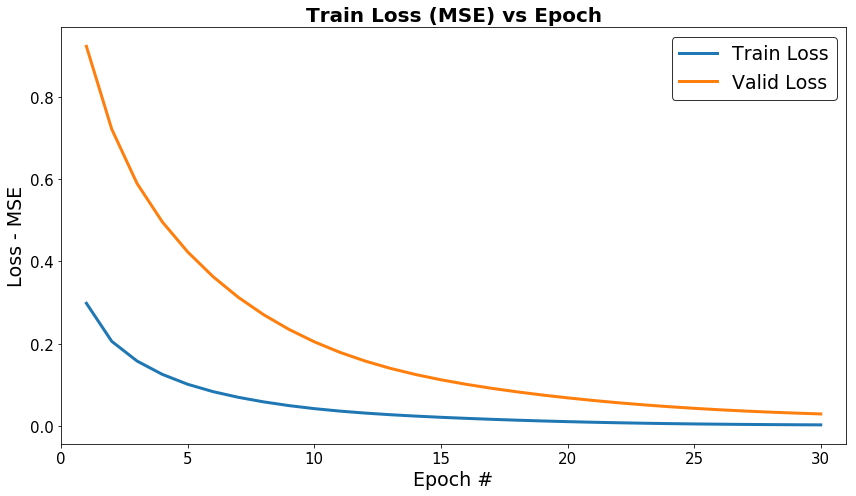

In [18]:
# plot history
figsize = (12, 7)
titlefontsize = 20
xtickfontsize = 15
ytickfontsize = 15
labelfontsize = 19
legendfontsize = 19
linewidth = 3
fig = plt.figure(figsize=figsize)
ax = fig.subplots(1, 1)
ax.plot(np.arange(1, n_epochs+1), history.history['loss'],
        "-",
        linewidth=linewidth,
        label='Train Loss')
ax.plot(np.arange(1, n_epochs+1), history.history['val_loss'],
        "-",
        linewidth=linewidth,
        label='Valid Loss')
ax.set_xlabel("Epoch #", fontsize=labelfontsize)
ax.set_ylabel("Loss - " + loss.upper(), fontsize=labelfontsize)
ax.tick_params(
    axis='x',          
    which='both',      
    labelsize=xtickfontsize)
ax.tick_params(
    axis='y',    
    labelsize=ytickfontsize)
ax.set_title("Train Loss " +  f"({loss})".upper() + " vs Epoch",
        fontsize=titlefontsize,
        fontweight="bold"
    )
ax.legend(loc="upper right",
          fontsize=legendfontsize,
          framealpha=0.8,
          fancybox=True,
          frameon=True,
          shadow=False,
          edgecolor="k")
ax.set_xlim([0, n_epochs+1])
plt.tight_layout()
fname = f"loss-plot-valid.png"
# fig.savefig(os.path.join(ROOT_DIR, "reports", "figures", fname), transparent=False, dpi=dpi)
plt.show()

In [19]:
# make a prediction
yhat_valid = model.predict(x_valid)

In [20]:
temp = x_valid.reshape((n_valid, n_lags*n_variables))
temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    y_valid.reshape((n_valid, n_sequences))
temp = temp.reshape((-1, n_variables))
y_valid = scaler.inverse_transform(temp)[:, index_target]

temp = x_valid.reshape((n_valid, n_lags*n_variables))
temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    yhat_valid.reshape((n_valid, n_sequences))
temp = temp.reshape((-1, n_variables))
yhat_valid = scaler.inverse_transform(temp)[:, index_target]

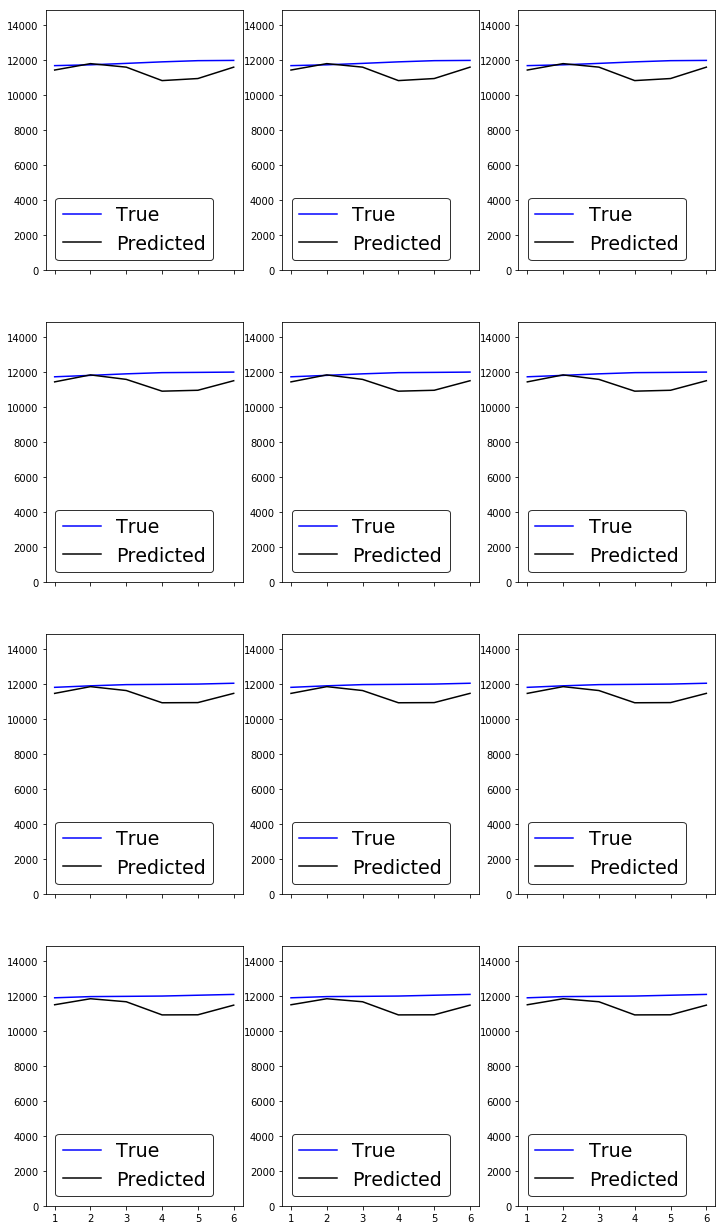

In [21]:
n = 12
ncols = 3
fig, axs = plt.subplots(nrows=int(np.ceil(n/ncols)),
                        ncols=ncols,
                        figsize=(12, 22),
                        sharex=True)
for k in range(n):
    i = k // ncols
    j = k % ncols
    axs[i, j].plot(np.arange(1,n_sequences+1),
                   y_valid[i*n_sequences:i*n_sequences+n_sequences],
                   color="blue",
                   label="True")
    axs[i, j].plot(np.arange(1,n_sequences+1),
                   yhat_valid[i*n_sequences:i*n_sequences+n_sequences],
                   color="black",
                   label="Predicted")
    
    
    axs[i, j].legend(loc="best",
                     fontsize=legendfontsize,
                     framealpha=0.8,
                     fancybox=True,
                     frameon=True,
                     shadow=False,
                     edgecolor="k")
    
    axs[i, j].set_ylim([0, 1.1*max(y_valid)])
#     print(y_valid[i*n_sequences:i*n_sequences+n_sequences].shape) 
    

Perform forecatsting

In [22]:
x_scaled = values_scaled[-n_lags:, :].reshape((1, -1)).reshape((-1, n_sequences, n_variables))

In [23]:
yhat_scaled = model.predict(x_scaled)

temp = x_scaled.reshape((1, n_lags*n_variables))

temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    yhat_scaled.reshape((1, n_sequences))
temp = temp.reshape((-1, n_variables))
yhat = scaler.inverse_transform(temp)[:, index_target]

In [24]:
start_date = df.index[-1] 
mrange = month_range(start_date, n_sequences+1)
data = []

trace = go.Scatter(
        x=list(df.index.astype(str).values),
        y=df.iloc[:, index_target],
        name="Original",
#         line = dict(color=colors[i]),
#         colorscale='Viridis',
        opacity = 0.9,
        mode="lines"
    )

trace_predict = go.Scatter(
        x=[d for d in mrange],
        y=list(df.values[-1:, index_target]) + list(yhat),
        name="Predict",
#         line = dict(color=colors[i]),
#         colorscale='Viridis',
        opacity = 0.9,
        mode="lines"
    )

data = [trace, trace_predict]

layout = dict(
    title=df.columns[index_target],
    yaxis= dict(title = df.columns[index_target]),
    xaxis=dict(
        title="Time",
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = df.columns[index_target])